In [3]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Load the configuration from the file
config.read('cfg.conf')

# Get the value of 'slide_path' under the section 'path_to_slide'
openslide_bin_path = config['path_to_slide']['openslide_path']
slide_photo_path = config['path_to_slide']['slide_local_path'] 
general_image_folder = config["images"]["general_path"]


In [4]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

if hasattr(os, 'add_dll_directory'):
    with os.add_dll_directory(openslide_bin_path):
        import openslide
else:
    import openslide

In [5]:
slide = openslide.OpenSlide(slide_photo_path)

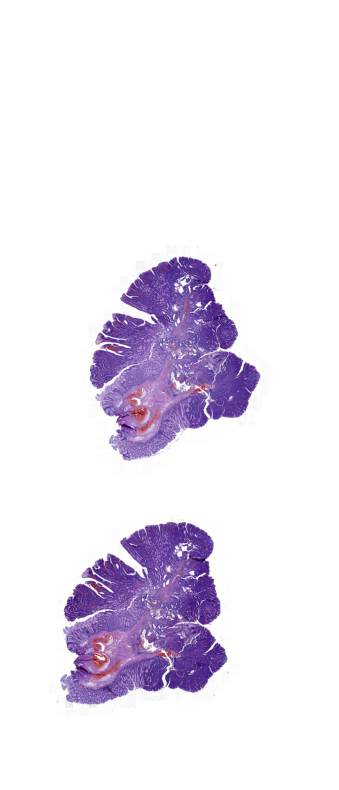

In [6]:
thumbnail_size = 1024
thumbnail = slide.get_thumbnail((thumbnail_size, thumbnail_size * slide.dimensions[1] // slide.dimensions[0]))

plt.figure(figsize=(10, 10))
plt.imshow(thumbnail)
plt.axis('off')  
plt.show()

In [7]:
def get_color_map(patch):
    
    r,g,b = patch.convert("RGB").split()
    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)


    #RED MASK
    red_diff_array = np.full_like(r_array, 30)
    red_mask = (r_array > cv2.add(b_array,red_diff_array) ) & (r_array > cv2.add(b_array,red_diff_array) )
    red_pixels = np.count_nonzero(red_mask)

    #ALL PIXLES
    pixels = np.count_nonzero(red_diff_array)

    #WHITE MASK 

    white_mask = (r_array>220)&(b_array>220)&(g_array>220)
    white_pixels = np.count_nonzero(white_mask)

    #BLACK MASK 
    black_mask = (r_array<30)&(b_array<30)&(g_array<30)
    black_pixels = np.count_nonzero(black_mask)

    #PURPLE MASK 
    purple_mask = (b_array>(cv2.add(r_array,g_array)))
    purple_pixels = np.count_nonzero(purple_mask)

    #PINK MASK
    average_pixels = (b_array.astype(int) + g_array.astype(int) + r_array.astype(int)) // 3
    pink_mask = (average_pixels > 150) & (average_pixels < 220)
    pink_pixels = np.count_nonzero(pink_mask)

    
    color_mask = np.zeros_like(r_array)
    color_mask[red_mask] = 120
    color_mask[white_mask] = 240
    color_mask[black_mask] = 10
    color_mask[purple_mask] = 60
    color_mask[pink_mask] = 180

    color_seperated_image = Image.fromarray(color_mask)
    
    return color_seperated_image, (pixels, white_pixels,red_pixels, black_pixels,purple_pixels,pink_pixels)



In [8]:
def divide_whole_slide_to_patches(slide, patch_size=(256, 256), high_threshold = 200, low_threshold = 30, early_stop = True, early_stop_number=100):
    slide_width, slide_height = slide.dimensions
    patch_width, patch_height = patch_size
    num = 1
    patches = []
    for y in range(0, slide_height, int(patch_height/2)):
        for x in range(0, slide_width, int(patch_width/2)):
            patch = slide.read_region((x, y), 0, patch_size)
            np_patch = np.array(patch)
            median_color = np.median(np_patch)
            if median_color < high_threshold and median_color > low_threshold:
                patches.append(patch)                
                num+=1  
            if num > 100 and early_stop_number:
                return patches
    return patches        

def extract_random_patches(slide, patch_size=(256, 256), num_patches=100, high_threshold = 200, low_threshold = 50):
    slide_width, slide_height = slide.dimensions
    patch_width, patch_height = patch_size
    patches = []

    while len(patches) < num_patches:
        x = np.random.randint(8192, slide_width - patch_width - 8192)
        y = np.random.randint(8192, slide_height - patch_height - 8192)
        
        patch = slide.read_region((x, y), 0, patch_size)
        
        np_patch = np.array(patch)
        median_color = np.median(np_patch)
        if median_color < high_threshold and median_color > low_threshold:
            patches.append(patch)        
            
    return patches





In [9]:
def save_patches_to_dir(patches, save_dir, base_folder = general_image_folder):
    os.makedirs(save_dir, exist_ok=True)
    save_dir = os.path.join(base_folder,save_dir)
    for index,patch in enumerate(patches):
        patch_filename = f"patch_{index}.png"
        patch_path = os.path.join(save_dir, patch_filename)
        patch.save(patch_path)
    
def seperate_patches(patches, save_dir, base_folder = general_image_folder):
    os.makedirs(save_dir, exist_ok=True)
    save_dir = os.path.join(base_folder,save_dir)
    cancer_folder = os.path.join(save_dir, "Cancer")
    no_cancer_folder = os.path.join(save_dir, "No-Cancer")
    os.makedirs(cancer_folder, exist_ok=True)
    os.makedirs(no_cancer_folder, exist_ok=True)
    for index,patch in enumerate(patches):
        patch_filename = f'patch_{index}.png'
        _ , (pixels, white_pixels,red_pixels, black_pixels,purple_pixels,pink_pixels) = get_color_map(patch)
        
        #IN CASE YOU WANT TO CHECK PERCENTAGES
        # str_with_values =f"{len(patches)}_purpletoall_{purple_pixels/(pixels-white_pixels):.2f}__purple_{purple_pixels/pixels:.2f}_pink_{pink_pixels/pixels:.2f}"
        # patch_filename = f'{str_with_values}.png'
        
        if (purple_pixels/(pixels-white_pixels))>0.2 and purple_pixels/pink_pixels > 1.1:
            cancer_folder = os.path.join(save_dir, "Cancer")
            patch_path = os.path.join(cancer_folder, patch_filename)
            patch.save(patch_path)
        else:
            no_cancer_folder = os.path.join(save_dir, "No-Cancer")
            patch_path = os.path.join(no_cancer_folder, patch_filename)
            patch.save(patch_path)

In [10]:
patches = extract_random_patches(slide)
seperate_patches(patches,"seperated")